In [1]:
import json
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2

# update as needed
bounding_boxes_json_path = "/Users/thomasmcconnell/Library/CloudStorage/OneDrive-PomonaCollege/School/CS153/Project/cs153-football-formation-id/yolo_player_detector/player_bboxes.json"
dataset_json_path = "/Users/thomasmcconnell/Library/CloudStorage/OneDrive-PomonaCollege/School/CS153/Project/cs153-football-formation-id/sample_data/sample_dataset.json"
path_to_data = "/Users/thomasmcconnell/Library/CloudStorage/OneDrive-PomonaCollege/School/CS153/Project/cs153-football-formation-id/sample_data"

with open(bounding_boxes_json_path, "r") as f:
    all_detections = json.load(f)
    
with open(dataset_json_path, "r") as f:
    dataset_metadata = [json.loads(line) for line in f]

Now that we have bounding boxes for player detection, we will create a model that uses these bounding boxes as input to predict formations.

In [2]:
# look for formation
video_to_formation = {}
for entry in dataset_metadata:
    video_to_formation[entry["video_path"]] = entry["off_formation"]

X = []  # Feature vectors
y = []  # Formation labels

for detection in all_detections:
    filename = detection["image_filename"]
    video_path = filename.replace("cropped_sideline_", "").replace(".png", "")
    formation_label = video_to_formation.get(video_path, None)
    if formation_label is None:
        continue

    # build feature vector
    player_positions = []
    for player in detection["players"]:
        x1, y1, x2, y2 = player["bbox"]
        cx = (x1 + x2) / 2  # center x
        cy = (y1 + y2) / 2  # center y
        player_positions.append([cx, cy])

    # flatten the player positions so we can use them as features
    max_players = 20
    flattened = np.array(player_positions).flatten()
    if len(flattened) < max_players * 2:
        flattened = np.pad(flattened, (0, max_players * 2 - len(flattened)))
    else:
        flattened = flattened[:max_players * 2]

    X.append(flattened)
    y.append(formation_label)

X = np.array(X)
y = np.array(y)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train random forest
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# evaluate
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        Aces       1.00      1.00      1.00         1
  KINGSSPLIT       0.50      1.00      0.67         1
      QUEENS       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



/Users/thomasmcconnell/Documents/venv/torch_cs153/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/thomasmcconnell/Documents/venv/torch_cs153/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/thomasmcconnell/Documents/venv/torch_cs153/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

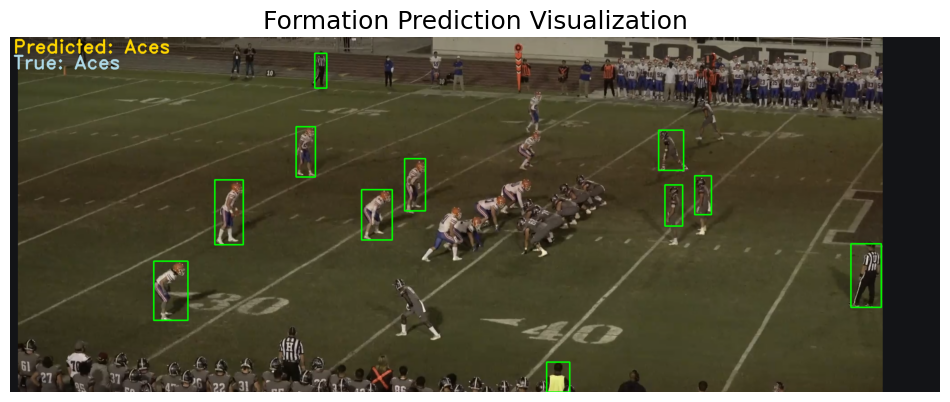

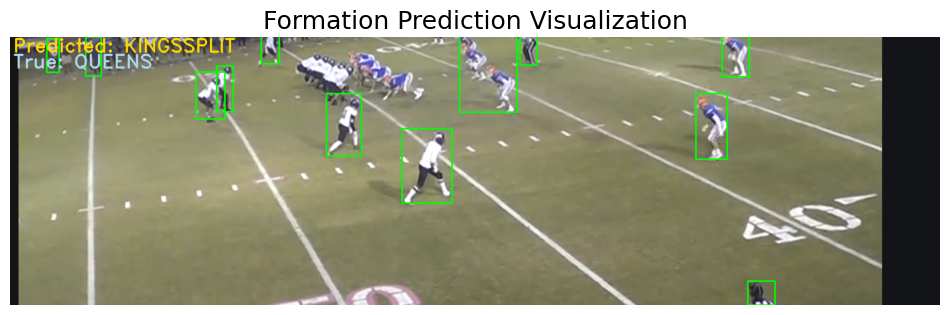

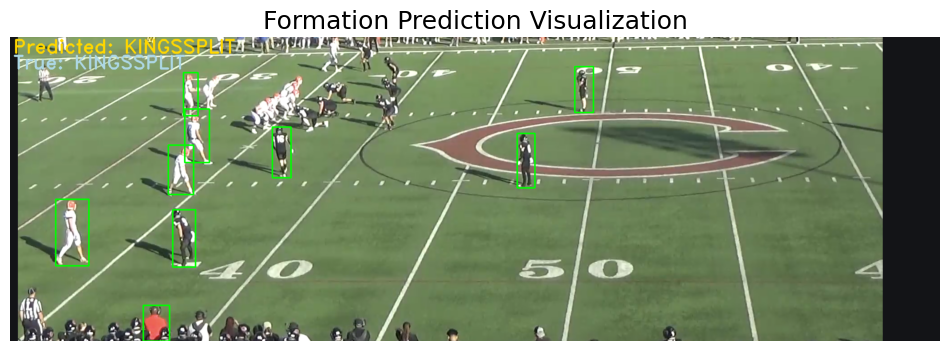

In [3]:
import matplotlib.pyplot as plt
import cv2

# pick random samples to display
num_samples_to_show = 5
demo_indices = np.random.choice(len(X_test), size=min(num_samples_to_show, len(X_test)), replace=False)

for idx in demo_indices:
    # Get the test sample
    sample = X_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    
    matching_index = np.where((X == sample).all(axis=1))[0]
    if len(matching_index) == 0:
        continue
    matching_index = matching_index[0]
    
    detection = all_detections[matching_index]
    filename = detection["image_filename"]
    
    found_path = None
    for root, dirs, files in os.walk(path_to_data):
        if filename in files:
            found_path = os.path.join(root, filename)
            break
    
    if found_path is None:
        continue

    # load
    image = cv2.imread(found_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # manually draw bounding boxes
    for player in detection["players"]:
        x1, y1, x2, y2 = player["bbox"]
        cv2.rectangle(
            image_rgb,
            (int(x1), int(y1)),
            (int(x2), int(y2)),
            color=(0, 255, 0),  # green
            thickness=3
        )

    # predicted vs true
    label_text = f"Predicted: {pred_label}"
    true_text = f"True: {true_label}"

    cv2.putText(
        image_rgb,
        label_text,
        (10, 50),
        cv2.FONT_HERSHEY_DUPLEX,
        2,
        (255, 215, 0),  # gold
        3
    )
    cv2.putText(
        image_rgb,
        true_text,
        (10, 100),
        cv2.FONT_HERSHEY_DUPLEX,
        2,
        (173, 216, 230),  # blue
        3
    )

    # Show
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.title("Formation Prediction Visualization", fontsize=18)
    plt.axis('off')
    plt.show()
